# Notebook to format data from ""Super machine learning: Improving accuracy and reducing variance of behaviour classification from accelerometry"", Ladds et al (2017).

Paper can be found [here](https://www.researchgate.net/publication/315746012_Super_machine_learning_Improving_accuracy_and_reducing_variance_of_behaviour_classification_from_accelerometry).

[Data](https://github.com/MoniqueLadds/behaviour_accelerometry)

## Setup

In [1]:
# Outputs:
# formatted dataset directory
# dataset_metadata (yaml), includes
## sample_rate
## dataset_label_names (list)
## dataset_feature_names (list)
## clip_ids (list)
# clip_data (directory), includes
## data_files (multiple files)

In [2]:
%load_ext autoreload
%autoreload 2

In [3]:
import os
import numpy as np
import pandas as pd
import h5py
from matplotlib import pyplot as plt
import glob
import yaml
from sklearn.decomposition import PCA
import scipy.signal as signal

In [4]:
# Specify data filepaths

raw_data_dir = '/home/jupyter/behavior_data_local/data/raw/ladds_seals/raw_data'
formatted_data_dir = '/home/jupyter/behavior_data_local/data/formatted/ladds_seals'

if not os.path.exists(formatted_data_dir):
    os.makedirs(formatted_data_dir)
    
data_fps = glob.glob(raw_data_dir + '/*/*.csv')

clip_data_dir = os.path.join(formatted_data_dir, 'clip_data')
if not os.path.exists(clip_data_dir):
    os.makedirs(clip_data_dir)

In [5]:
# Set up metadata, individuals

# Dataset metadata
dataset_metadata = {}
sr = 25
dataset_metadata['sr'] = sr ## from dataset documentation
dataset_metadata['dataset_name'] = 'ladds_seals'

individuals = []
for fp in data_fps:
    individual = fp.split('/')[-2]
    individuals.append(individual)
    
# make a list of individuals
individuals = list(set(individuals))
individuals.sort()

In [6]:
# Set up data splits: divide individuals across folds for cross validation

n_folds = 5
dataset_metadata['n_folds'] = n_folds
individuals_per_fold = {i : [] for i in range(n_folds)}

individual_to_individual_id = {individual : i for i, individual in enumerate(individuals)}

for pointer, individual in enumerate(individuals):
    individuals_per_fold[pointer % n_folds].append(individual_to_individual_id[individual])
    
dataset_metadata['individuals_per_fold'] = individuals_per_fold
    
print(individuals_per_fold)
print("There are %d individuals" % len(individuals))

{0: [0, 5, 10], 1: [1, 6, 11], 2: [2, 7], 3: [3, 8], 4: [4, 9]}
There are 12 individuals


In [7]:
# Set up clip ids

# Clip ids
clip_ids = []
for fp in data_fps:
    individual = fp.split('/')[-2]
    fn = fp.split('/')[-1]
    clip_id = individual + '-' + fn.split('.')[0]
    clip_ids.append(clip_id)
    
dataset_metadata['clip_ids'] = clip_ids

In [8]:
## Integer codes for individuals


clip_id_to_individual_id = {clip_id : individual_to_individual_id[clip_id.split('-')[0]] for clip_id in clip_ids}

dataset_metadata['individual_ids'] = [i for i, individual in enumerate(individuals)] # 
dataset_metadata['clip_id_to_individual_id'] = clip_id_to_individual_id

In [9]:
# Set up clip ids 

clip_ids_per_fold = {i : [] for i in range(n_folds)}
for clip_id in clip_ids:
    individual = clip_id_to_individual_id[clip_id]
    for fold in range(n_folds):
        if individual in individuals_per_fold[fold]:
            clip_ids_per_fold[fold].append(clip_id)
for fold in range(n_folds):
    clip_ids_per_fold[fold] = sorted(clip_ids_per_fold[fold])

dataset_metadata['clip_ids_per_fold'] = clip_ids_per_fold

## Create dataset-level metadata

In [10]:
## Integer codes for specific behaviors

# list of behaviors (from Jeantet et al 2020)
beh_names = ['unknown', 
             'travelling',
             'resting',
             'grooming',
             'feeding'
            ]

dataset_metadata['label_names'] = beh_names

beh_str_to_int = {name : i for i, name in enumerate(beh_names)}
beh_int_to_str = {i : name for i, name in enumerate(beh_names)}

# extract directly from the annotations
fp = data_fps[0]
all_annotations = pd.read_csv(fp)

for fp in data_fps[1:]:
    all_annotations = all_annotations.append(pd.read_csv(fp))

/opt/conda/lib/python3.7/site-packages/IPython/core/interactiveshell.py:3552: DtypeWarning: Columns (4) have mixed types.Specify dtype option on import or set low_memory=False.
  exec(code_obj, self.user_global_ns, self.user_ns)


In [11]:
# What are the observed labels?

all_annotations['type'].value_counts()

Travelling    502640
Foraging      303698
Other         213424
Resting       179637
Grooming       59021
Name: type, dtype: int64

In [12]:
# Map to beh_labels following labels in published article (4 label scheme)

observed_labels_to_beh_label = {'Travelling' : 'travelling',
                                'Foraging' : 'feeding',
                                'Other' : 'unknown',
                                'Resting' : 'resting',
                                'Grooming' : 'grooming'
                               }

In [13]:
## clip_data column names

clip_column_names = ['AccX', 'AccY', 'AccZ', 'Depth', 'individual_id', 'label']
dataset_metadata['clip_column_names'] = clip_column_names

In [14]:
## Save off dataset level metadata

dataset_metadata_fp = os.path.join(formatted_data_dir, 'dataset_metadata.yaml')

with open(dataset_metadata_fp, 'w') as file:
    yaml.dump(dataset_metadata, file)

## Format Clip Data

In [15]:
# Standard practice is to remove gravitational bias from each accel channel by applying a boxcar filter, then subtract the result

# Convenience function to detect nans.
def nan_helper(y):
    return np.isnan(y), lambda z: z.nonzero()[0]

#Interpolates all nan values of given array
def interpolate_nan(y):
    nans, x= nan_helper(y)
    y[nans]= np.interp(x(nans), x(~nans), y[~nans])
    return y

In [16]:
# For each clip, create and save the data in the correct format

total_dur_samples = 0
total_annotation_dur_samples = 0

for clip_id in clip_ids:
    # load features
    data_fp = os.path.join(raw_data_dir, clip_id.split('-')[0], '-'.join(clip_id.split('-')[1:]) + '.csv')
    
    clip_df = pd.read_csv(data_fp)
    
    clip_dur_samples = len(clip_df)
    
    total_dur_samples += clip_dur_samples
    
    # Correct for gravitational bias and remove nans
    per_frame_AccX = np.array(clip_df['x'])
    per_frame_AccX = interpolate_nan(per_frame_AccX)
    
    per_frame_AccY = np.array(clip_df['y'])
    per_frame_AccY = interpolate_nan(per_frame_AccY)
    
    per_frame_AccZ = np.array(clip_df['z'])
    per_frame_AccZ = interpolate_nan(per_frame_AccZ)
    
    per_frame_Depth = np.array(clip_df['depth'])
    per_frame_Depth = interpolate_nan(per_frame_Depth) ## there is a short period of nans in one depth track
    
    # reformat
    per_frame_AccX = np.expand_dims(per_frame_AccX, axis = -1)
    per_frame_AccY = np.expand_dims(per_frame_AccY, axis = -1)
    per_frame_AccZ = np.expand_dims(per_frame_AccZ, axis = -1)
    per_frame_Depth = np.expand_dims(per_frame_Depth, axis = -1)
    
    per_frame_annotations = np.expand_dims(np.array(clip_df['type'].map(lambda x: beh_str_to_int[observed_labels_to_beh_label[x]])), axis = -1)
    
    individual_id = clip_id_to_individual_id[clip_id]
    per_frame_individual_id = np.full_like(per_frame_annotations, individual_id)
    
    clip_data = np.concatenate([per_frame_AccX,
                                per_frame_AccY, 
                                per_frame_AccZ,
                                per_frame_Depth, 
                                per_frame_individual_id, 
                                per_frame_annotations], axis = 1)
    
    clip_data_fp = os.path.join(clip_data_dir, clip_id + '.csv')
    np.savetxt(clip_data_fp, clip_data, delimiter=",")
    
    clip_annotation_dur_samples = np.sum(per_frame_annotations > 0)
    total_annotation_dur_samples += clip_annotation_dur_samples

In [17]:
total_dur_sec = total_dur_samples / sr
total_dur_hours = total_dur_sec / 3600
print("total duration is %f seconds, i.e. %f hours" % (total_dur_sec, total_dur_hours))

total_annotation_dur_sec = total_annotation_dur_samples / sr
total_annotation_dur_hours = total_annotation_dur_sec / 3600
print("total annotation duration is %f seconds, i.e. %f hours" % (total_annotation_dur_sec, total_annotation_dur_hours))

total duration is 50336.800000 seconds, i.e. 13.982444 hours
total annotation duration is 41799.840000 seconds, i.e. 11.611067 hours


## Check it all looks ok

In [18]:
clip_id = clip_ids[4]
clip_data_fp = os.path.join(clip_data_dir, clip_id + '.csv')
data = np.genfromtxt(clip_data_fp, delimiter = ',')

In [19]:
np.shape(data)

(9545, 6)

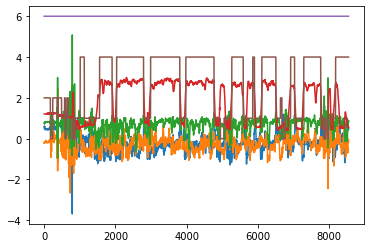

In [20]:
for i in range(np.shape(data)[1]):
    plt.plot(data[1000:11000, i])

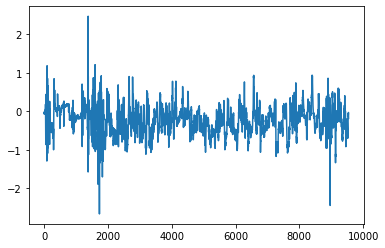

In [21]:
plt.plot(data[:, 1])

## Plot Dataset Summary

In [22]:
# Count class representation

beh_names = dataset_metadata['label_names']
label_count = {fold : {name : 0 for name in beh_names} for fold in range(n_folds)}

for clip_id in clip_ids:
    clip_data_fp = os.path.join(clip_data_dir, clip_id + '.csv')
    data = pd.read_csv(clip_data_fp, delimiter = ',', header = None)
    counts = data[data.keys()[-1]].astype(int).value_counts()
    for key in counts.keys():
        name = beh_names[key]
        for fold in range(n_folds):
            if clip_id in dataset_metadata['clip_ids_per_fold'][fold]:
                label_count[fold][name] += counts[key]
                
label_perc = {fold : {name : 0 for name in beh_names[1:]} for fold in range(n_folds)}

for name in beh_names[1:]:
    for fold in range(n_folds):
        label_perc[fold][name] = float(label_count[fold][name] / sum([label_count[fold][j] for j in beh_names[1:]]))


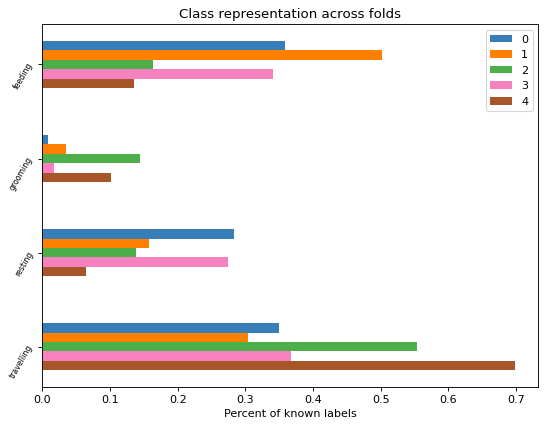

In [26]:
# Plot class representation

# https://gist.github.com/thriveth/8560036#file-cbcolors-py
CB_color_cycle = ['#377eb8', '#ff7f00', '#4daf4a',
                  '#f781bf', '#a65628', '#984ea3',
                  '#999999', '#e41a1c', '#dede00']

keys = np.arange(len(beh_names))[1:]
offset = 0.1
width = 0.1
plt.figure(figsize=(8, 6), dpi=80)

for fold in range(n_folds):
    current_offset = -(fold - n_folds // 2)*offset
    plt.barh(keys +current_offset, [label_perc[fold][beh_names[key]] for key in keys], height=width, align='center', label = fold, color = CB_color_cycle[fold])
    
plt.title("Class representation across folds")
plt.yticks(keys, beh_names[1:], fontsize = 7, rotation = 60)
plt.xlabel('Percent of known labels')
plt.legend()
target_fp = os.path.join(formatted_data_dir, 'class_rep.svg')

plt.savefig(target_fp, format = 'svg')
plt.show()

numerical_target_fp = os.path.join(formatted_data_dir, 'class_rep.yaml')
with open(numerical_target_fp, 'w') as file:
    yaml.dump(label_perc, file)

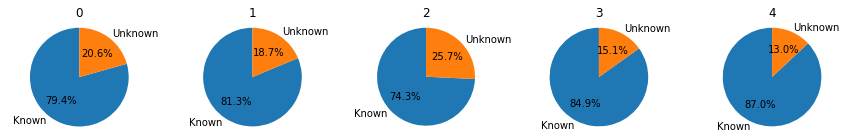

In [27]:
# Pie chart, of known vs unknown samples 

labels = 'Known', 'Unknown'
sizes = {fold : [sum([label_count[fold][j] for j in beh_names[1:]]), label_count[fold]['unknown']] for fold in range(n_folds)}
# train_sizes = [sum([train_label_count[j] for j in beh_names[1:]]), train_label_count['unknown']]
# val_sizes = [sum([val_label_count[j] for j in beh_names[1:]]), val_label_count['unknown']]
# test_sizes = [sum([test_label_count[j] for j in beh_names[1:]]), test_label_count['unknown']]

fig, ax = plt.subplots(1,n_folds, figsize = (3*n_folds,2))

for fold in range(n_folds):
    ax[fold].pie(sizes[fold], labels=labels, autopct='%1.1f%%', startangle=90)
    ax[fold].axis('equal')  # Equal aspect ratio ensures that pie is drawn as a circle.
    ax[fold].set_title(fold)

target_fp = os.path.join(formatted_data_dir, 'perc_known.svg')

plt.savefig(target_fp, format='svg')

plt.show()


## Temporal Statistics

In [25]:
####################################
infill_max_dur_sec = 0 # If annotations are nnnnn0000000nnnnn, where 0=unknown, do we fill in 0's with n's?
####################################

# This cell runs almost as a stand alone, but requires the first few cells of this notebook to be run first

import tqdm
from pathlib import Path

dataset_metadata_fp = os.path.join(formatted_data_dir, 'dataset_metadata.yaml')

with open(dataset_metadata_fp, 'r') as file:
    metadata = yaml.safe_load(file)

clip_fps = list(Path(clip_data_dir).glob('*.csv'))

def create_list_of_durations(x, infill_max_dur_sec, samplerate, unknown_value = 0):
    # First pass: create a list of label durations, together with a list of the associated classes
    current_value = 0
    current_dur = 0
    list_of_durs = []
    list_of_labels = []
    for i in x:
        if i == current_value:
            current_dur += 1
        elif i != current_value:
            list_of_durs.append(current_dur / samplerate)
            list_of_labels.append(current_value)
            current_dur = 1
            current_value = i
            
    list_of_durs.append(current_dur)
    list_of_labels.append(current_value)
            
    # repeatedly merge similar labels if they are seperated by unknowns of short duration
    # This is mainly to deal with duty cycling of observations
    infill_max_dur_samples = int(infill_max_dur_sec * samplerate)
    
    if list_of_labels[0] == unknown_value:
        del list_of_labels[0]
        del list_of_durs[0]
        
    if list_of_labels[-1] == unknown_value:
        del list_of_labels[-1]
        del list_of_durs[-1]
    
    j = 1
    while j<len(list_of_labels)-1:
        if list_of_labels[j] != unknown_value:
            j+= 1
        elif list_of_labels[j-1] == list_of_labels[j+1] and list_of_durs[j] < infill_max_dur_samples:
            # merge if it's a short interval of unknowns between two of the same label
            list_of_durs[j-1] += list_of_durs[j+1]
            del list_of_durs[j+1]
            del list_of_durs[j]
            del list_of_labels[j+1]
            del list_of_labels[j]
        else:
            # otherwise, drop the unknown segment
            del list_of_durs[j]
            del list_of_labels[j]

    return list_of_labels, list_of_durs # list of annotation durations, in samples.
                             
durs_sec_by_individual = {i : [] for i in metadata['individual_ids']}
overall_durs_sec = []
    
for fp in tqdm.tqdm(clip_fps):
    clip_id = fp.stem
    individual_id = metadata['clip_id_to_individual_id'][clip_id]
    clip_annotations = list(pd.read_csv(fp, header = None).values[:, -1])
    l, d = create_list_of_durations(clip_annotations, infill_max_dur_sec, metadata['sr'])
    durs_sec_by_individual[individual_id].extend(d)
    overall_durs_sec.extend(d)
    
mean_dur_sec_by_individual = {i : float(np.mean(durs_sec_by_individual[i])) for i in durs_sec_by_individual}
mean_overall_dur_sec = float(np.mean(overall_durs_sec))

metadata['mean_dur_sec_by_individual'] = mean_dur_sec_by_individual
metadata['mean_overall_dur_sec'] = mean_overall_dur_sec

print("Mean overall label duration is %0.3f seconds" % mean_overall_dur_sec)

print("Re-saving metadata to %s" % str(dataset_metadata_fp))

with open(dataset_metadata_fp, 'w') as file:
    yaml.dump(metadata, file)

100%|██████████| 72/72 [00:02<00:00, 33.37it/s]


Mean overall label duration is 24.847 seconds
Re-saving metadata to /home/jupyter/behavior_data_local/data/formatted/ladds_seals/dataset_metadata.yaml
